In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def yieldFunction(stress, p0):
    # stress is a (6,1) array with sigma11, sigma22, sigma33(sigma22=sigma33), 12,13,23
    pp = getp(stress)
    q = getq(stress)
    f = M**2 * pp**2 - M**2 * p0 * pp + q**2
    return f

In [16]:
def getp(stress):
    p = sum(stress[:3,0])/3.
    return p

In [17]:
def getq(stress):
    # only for traxial
    q = stress[0,0] - stress[2,0]
    return q

In [18]:
def getDevStress(stress):
    # get deviatoric stress (3,3) matrix from stress
    stressMat = np.array([stress[0,0], stress[3,0], stress[4,0], stress[3,0], stress[1,0], stress[5,0], stress[4,0], stress[5,0], stress[2,0]]).reshape(3,3)
    p = getp(stress)
    devStress = stressMat - p * np.eye(3)
    return devStress

In [19]:
def getDevStrain(strain):
    # get deviatoric strain from strain
    devStrain = 2./3 * (strain[0,0] - strain[2,0])
    return devStrain

In [20]:
def yfGrad(stress, p0):
    # the derivative of yield function to stress, (6,1) array
    p = getp(stress)
    df = M**2 * (2*p - p0) / 3. * np.eye(3) + 3 * getDevStress(stress)
    df = np.array([df[0,0], df[1,1], df[2,2], df[0,1], df[0,2], df[1,2]]).reshape(-1,1)
    return df

In [21]:
def yfGradhp(stress):
    #the derivative of yield function to hardening parameter, here is p0
    p = getp(stress)
    dfhp = -M**2 * p
    return dfhp

In [35]:
def elasticMat(stress, e0):
    # the elastic stress-strain matrix (6,6)
    p = getp(stress)
    K = float(1+e0)/Kappa * p
    G = 3*(1-2.*mu)/2./(1+mu) * K
    l = 3*mu*K/(1+mu)
    De = np.array([l+2*G, l, l, 0, 0, 0, l, l+2*G, l, 0, 0, 0, l, l, l+2*G, 0, 0, 0, 0, 0, 0, G, 0, 0, 0, 0, 0, 0, G, 0, 0, 0, 0, 0, 0, G]).reshape(6,6)
    return De

In [23]:
def modifiedRF(stress0, p0, deltaStress, a0=0, a1=1, MAX=10):
    # modified Regula-Falsi Intersection Scheme
    Fs = yieldFunction(stress0, p0)
    F0 = yieldFunction(stress0 + a0 * deltaStress, p0)
    F1 = yieldFunction(stress0 + a1 * deltaStress, p0)
    for i in range(MAX):
        a = a1 - (a1 - a0) * F1 / (F1 - F0)
        Fn = yieldFunction(stress0 + a * deltaStress, p0)
        if abs(Fn) < FTOL:
            break
        if Fn * F0 < 0:
            a1 = a
            F1 = Fn
            if Fn * Fs > 0:
                F0 = F0/2.
        else:
            a0 = a
            F0 = Fn
            if Fn * Fs > 0:
                F1 = F1/2.
        Fs = Fn
    else:
        raise Exception('Convergence not achieved after '+str(MAX)+' iterations!')
        
    return a    

In [24]:
def modifiedRF_NPM(stress0, p0, deltaStress, NSUB=10, MAX=3):
    a0 = 0
    a1 = 1
    F0 = yieldFunction(stress0, p0)
    for i in range(MAX):
        deltaA = float(a1 - a0) / NSUB
        for j in range(NSUB):
            a = a0 + deltaA
            stress1 = stress0 + a * deltaStress
            if yieldFunction(stress1, p0) > FTOL:
                a1 = a
                if F0 < -FTOL:
                    t = 1 # t used as a sign to decide whether to break one or two iterations
                    break
                else:
                    a0 = 0
                    t = -1
                    break
            else:
                a0 = a
                F0 = yieldFunction(stress1, p0)
        else:
            continue
        if t == 1:
            break
    else:
        raise Exception('Intersection not found after '+str(MAX)+' iterations!')
    # the above gives out (a0, a1)
    a = modifiedRF(stress0, p0, deltaStress, a0, a1)
    return a   
    

In [39]:
def correction(stress0, p0, e0, MAX=8):
    for i in range(MAX):
        f0 = yieldFunction(stress0, p0)
        a0 = b0 = yfGrad(stress0, p0)
        De = elasticMat(stress0, e0)
        MM = np.diag([1, 1, 1, 0.5, 0.5, 0.5])
        # strain hardening
        h0 = np.sqrt(2/3. * np.dot(np.dot(b0.T, MM), b0))
        A0 = -yfGradhp(stress0) * h0
        deltaLam = f0 / (A0 + np.dot(np.dot(a0.T, De), b0))
        stress = stress0 - deltaLam * np.dot(De, b0)
        p1 = p0 + deltaLam * h0
        if abs(yieldFunction(stress, p1)) > abs(yieldFunction(stress0, p0)):
            deltaLam = f0 / (np.dot(a0.T, a0))
            stress = stress0 - deltaLam * a0
            p1 = p0
        if abs(yieldFunction(stress, p1)) <= FTOL:
            break
        stress0 = stress
        p0 = p1
        
    else:
        raise Exception('Convergence not achieved after '+str(MAX)+' iterations!')
    return stress, p1

In [133]:
def computeDelta(stress0, p0, deltaT, deltaStressp, e0):
    # compute deltaStress and delta hardening parameter(p0) during plastic integration for each substep based on current stress and p0
    a = b = yfGrad(stress0, p0)
    De = elasticMat(stress0, e0)

    # both strain hardening and work hardening cannot work!! why??
    '''
    # strain hardening
    MM = np.diag([1, 1, 1, 0.5, 0.5, 0.5])
    h = np.sqrt(2/3. * np.dot(np.dot(b.T, MM), b))
    A = -yfGradhp(stress0) * h
    deltaLam = max(deltaT * np.dot(a.T, deltaStressp) / (A + np.dot(np.dot(a.T, De), b)), 0)
    deltaS = deltaT * deltaStressp - deltaLam * np.dot(De, b)
    deltaP = deltaLam * h
    # work hardening
    h = np.dot(stress0.T, b)
    A = -yfGradhp(stress0) * h
    deltaLam = max(deltaT * np.dot(a.T, deltaStressp) / (A + np.dot(np.dot(a.T, De), b)), 0)
    deltaS = deltaT * deltaStressp - deltaLam * np.dot(De, b)
    deltaP = deltaLam * h
    '''
    h = p0 * (1+e0) / (Lam - Kappa) * sum(yfGrad(stress0, p0)[:3,0])
    A = -yfGradhp(stress0) * h
    deltaLam = max(deltaT * np.dot(a.T, deltaStressp) / (A + np.dot(np.dot(a.T, De), b)), 0)
    deltaS = deltaT * deltaStressp - deltaLam * np.dot(De, b)
    deltaP = deltaLam * h
    # delta stress and delta p0 for each substep
    return deltaS, deltaP

In [134]:
def MCC_triaxialCP(p0, OCR, e0, maxStrain, strainRate=1e-4):
    # p0 is the initial pressure on NCL
    # OCR: over consolidated ratio
    # e0: void ratio at the starting state(not necessarily the same as p0)
    # maxStrain is the maximum axial strain
    # strainRate: positive means compression
    p0 = p0
    p0All = np.array(p0).reshape(-1,1)
    e0 = e0
    stress00 = p0/float(OCR)
    stress0 = np.array([stress00, stress00, stress00, 0, 0, 0]).reshape(-1,1)
    stressAll = stress0
    strain = np.zeros((6,1))
    strainAll = strain
    
    while strain[0,0] <= maxStrain:
        deltaStrain = np.array([strainRate, -0.5*strainRate, -0.5*strainRate, 0, 0, 0]).reshape(-1,1)
        strain = strain + deltaStrain
        strainAll = np.concatenate((strainAll, strain), axis=1)
        De = elasticMat(stress0, e0)
        deltaStress = np.dot(De, deltaStrain)
        stress = stress0 + deltaStress

        if yieldFunction(stress, p0) <= FTOL:
            # purely elastic
            stress0 = stress
            stressAll = np.concatenate((stressAll, stress0), axis=1)
            p0All = np.concatenate((p0All, np.array(p0).reshape(-1,1)), axis=1)
            continue
    
        if yieldFunction(stress0, p0) < -FTOL:
            alpha = modifiedRF(stress0, p0, deltaStress)
        elif yieldFunction(stress0, p0) <= FTOL:
            a = yfGrad(stress0, p0)
            cosT = np.dot(a.T, deltaStress) / np.linalg.norm(a) / np.linalg.norm(deltaStress)
            if cosT > -LTOL:
                # purely plastic
                alpha = 0
            else:
                alpha = modifiedRF_NPM(stress0, p0, deltaStress)
        else:
            raise Exception('The stress state is illegal!')
    
        stress0 = stress0 + alpha * deltaStress
        deltaStressp = (1-alpha) * deltaStress # the portion that causes plastic deformation
    
        T = 0
        deltaT = 1
        sign = 0 # to label whether the previous step ever failed
        while T < 1:        
            deltaS1, deltaP1 = computeDelta(stress0, p0, deltaT, deltaStressp, e0)
            deltaS2, deltaP2 = computeDelta(stress0+deltaS1, p0+deltaP1, deltaT, deltaStressp, e0)
            stress1 = stress0 + (deltaS1 + deltaS2) * 0.5
            p1 = p0 + (deltaP1 + deltaP2) * 0.5
            R = max(np.linalg.norm(deltaS2 - deltaS1)/np.linalg.norm(stress1)*0.5, np.linalg.norm(deltaP2 - deltaP1)/np.linalg.norm(p1)*0.5, EPS)
            if R > STOL:
                q = max(0.9 * np.sqrt(STOL/R), 0.1)
                deltaT = max(q * deltaT, deltaTmin)
                sign = 1
                continue
            stress0 = stress1
            p0 = p1
            T = T + deltaT
            if abs(yieldFunction(stress0, p0)) > FTOL:
                stress0, p0 = correction(stress0, p0, e0)
        
            # determine deltaT of next time step
            q = max(0.9 * np.sqrt(STOL/R), 1.1)
            if sign:
                q = min(q, 1)
                sign = 0
            deltaT = max(q * deltaT, deltaTmin)
            deltaT = min(deltaT, 1 - T)
        
        stressAll = np.concatenate((stressAll, stress0), axis=1)
        p0All = np.concatenate((p0All, np.array(p0).reshape(-1,1)), axis=1)
    print('Computation complete!')
    # stressAll and strainAll are (6,x) array with (xx,yy,zz,xy,xz,yz)
    return stressAll, strainAll, p0All

In [91]:
M = 1.021
Lam = 0.1041
Kappa = 0.0232
mu = 0.25

STOL = 1e-6
FTOL = 1e-9
LTOL = 1e-6
EPS = 1e-16
deltaTmin = 1e-4 

In [135]:
stressAll1, strainAll1, p1 = MCC_triaxialCP(p0=392, OCR=1.3, e0=0.98, maxStrain=0.08)

Computation complete!


In [139]:
stressAll2, strainAll2, p2 = MCC_triaxialCP(p0=392, OCR=4, e0=1., maxStrain=0.08)

Computation complete!


In [137]:
stressAll3, strainAll3, p3 = MCC_triaxialCP(p0=392, OCR=12, e0=1.03, maxStrain=0.08)

Computation complete!


In [197]:
expData = {}
# (3,x) array with p,q,axialStrain(deviatoricStrain)
expData['1.3'] = np.array([306,305,295,261,228,212,206,0,80,124,176,200,210,208,0,0.1,0.2,0.9,2.4,6,8]).reshape(3,-1)
print(expData['1.3'].shape)
expData['4.0'] = np.array([98,103,110,123,130,142,149,151,176,0,37,75,100,129,150,165,174,180,0,0.2,0.3,0.5,1,1.6,2,3,8]).reshape(3,-1)
print(expData['4.0'].shape)
expData['12'] = np.array([33,36,48,55,71,92,118,130,145,0,23,54,76,100,129,148,152,151,0,0.4,1,1.5,2,3,4,6,8]).reshape(3,-1)
print(expData['12'].shape)

(3, 7)
(3, 9)
(3, 9)


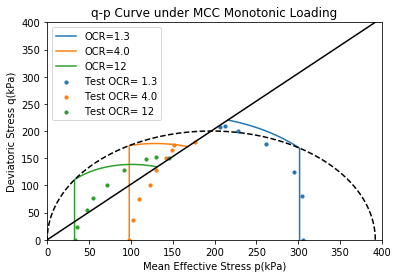

In [214]:
dataAll = [[stressAll1, strainAll1], [stressAll2, strainAll2], [stressAll3, strainAll3]]
OCR = ['1.3', '4.0', '12']
for data,ocr in zip(dataAll, OCR):
    pp = []
    qq = []
    devStrain = []
    m = data[0].shape[1]
    for i in range(m):
        pp.append(getp(data[0][:, i].reshape(-1,1)))
        qq.append(getq(data[0][:, i].reshape(-1,1)))
        devStrain.append(getDevStrain(data[1][:, i].reshape(-1,1)))
    plt.plot(pp,qq, label='OCR='+ocr)
for ocr in OCR:
    pp = expData[ocr][0,:]
    qq = expData[ocr][1,:]
    devStrain = expData[ocr][2,:]
    plt.scatter(pp,qq,s=40,marker='.',label='Test '+'OCR= '+ocr)
    
al = np.arange(0, np.pi, 0.01)
p00 = 392
x = p00/2.+p00/2.*np.cos(al)
y = p00/2.*M*np.sin(al)
plt.plot(x,y,'k--')
x = np.arange(0,400)
y = M * x
plt.plot(x,y,'k-')

plt.title('q-p Curve under MCC Monotonic Loading')
plt.xlabel('Mean Effective Stress p(kPa)')
plt.ylabel('Deviatoric Stress q(kPa)')
plt.legend()
plt.axis([0,400,0,400])
#plt.axis('equal')
plt.savefig('q-p curve Mono.png', dpi=120)
plt.show()

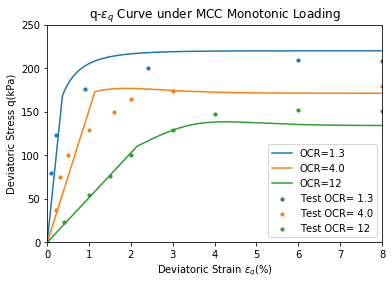

In [216]:
dataAll = [[stressAll1, strainAll1], [stressAll2, strainAll2], [stressAll3, strainAll3]]
OCR = ['1.3', '4.0', '12']
for data,ocr in zip(dataAll, OCR):
    pp = []
    qq = []
    devStrain = []
    m = data[0].shape[1]
    for i in range(m):
        pp.append(getp(data[0][:, i].reshape(-1,1)))
        qq.append(getq(data[0][:, i].reshape(-1,1)))
        devStrain.append(getDevStrain(data[1][:, i].reshape(-1,1))*100)
    plt.plot(devStrain,qq, label='OCR='+ocr)
for ocr in OCR:
    pp = expData[ocr][0,:]
    qq = expData[ocr][1,:]
    devStrain = expData[ocr][2,:]
    plt.scatter(devStrain,qq,s=40,marker='.',label='Test '+'OCR= '+ocr)

plt.title('q-$\epsilon_q$ Curve under MCC Monotonic Loading')
plt.xlabel('Deviatoric Strain $\epsilon_q$(%)')
plt.ylabel('Deviatoric Stress q(kPa)')
plt.legend()
plt.axis([0,8,0,250])
plt.savefig('q-strain curve Mono.png', dpi=120)
plt.show()

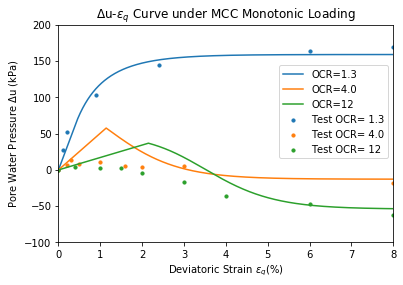

In [296]:
dataAll = [[stressAll1, strainAll1], [stressAll2, strainAll2], [stressAll3, strainAll3]]
OCR = ['1.3', '4.0', '12']
for data,ocr in zip(dataAll, OCR):
    pp = []
    qq = []
    devStrain = []
    m = data[0].shape[1]
    for i in range(m):
        pp.append(getp(data[0][:, i].reshape(-1,1)))
        qq.append(getq(data[0][:, i].reshape(-1,1)))
        devStrain.append(getDevStrain(data[1][:, i].reshape(-1,1))*100)
    ppp = np.array(qq)/3. + pp[0] 
    deltaU = ppp - pp
    plt.plot(devStrain,deltaU,label='OCR='+ocr)
for ocr in OCR:
    pp = expData[ocr][0,:]
    qq = expData[ocr][1,:]
    devStrain = expData[ocr][2,:]
    ppp = np.array(qq)/3. + pp[0] 
    deltaU = ppp - pp
    plt.scatter(devStrain,deltaU,s=40,marker='.',label='Test '+'OCR= '+ocr)

plt.title('$\Delta$u-$\epsilon_q$ Curve under MCC Monotonic Loading')
plt.xlabel('Deviatoric Strain $\epsilon_q$(%)')
plt.ylabel('Pore Water Pressure $\Delta$u (kPa)')
plt.legend(loc=5,bbox_to_anchor=(1.0,0.6))
plt.axis([0,8,-100,200])
plt.savefig('u-Strain curve Mono.png', dpi=120)
plt.show()


In [236]:
def MCC_cyclic(p0, OCR, e0, maxStress, cycleM=5, strainRate=1e-4):
    # p0 is the initial pressure on NCL
    # OCR: over consolidated ratio
    # e0: void ratio at the starting state(not necessarily the same as p0)
    # maxStrain is the maximum axial strain
    # strainRate: positive means compression
    p0 = p0
    p0All = np.array(p0).reshape(-1,1)
    e0 = e0
    stress00 = p0/float(OCR)
    stress0 = np.array([stress00, stress00, stress00, 0, 0, 0]).reshape(-1,1)
    stressAll = stress0
    strain = np.zeros((6,1))
    strainAll = strain
    
    cycle = 0

    while cycle < cycleM:
        deltaStrain = np.array([strainRate, -0.5*strainRate, -0.5*strainRate, 0, 0, 0]).reshape(-1,1)
        strain = strain + deltaStrain
        strainAll = np.concatenate((strainAll, strain), axis=1)
        De = elasticMat(stress0, e0)
        deltaStress = np.dot(De, deltaStrain)
        stress = stress0 + deltaStress

        if yieldFunction(stress, p0) <= FTOL:
            # purely elastic
            stress0 = stress
            stressAll = np.concatenate((stressAll, stress0), axis=1)
            p0All = np.concatenate((p0All, np.array(p0).reshape(-1,1)), axis=1)
            continue
    
        if yieldFunction(stress0, p0) < -FTOL:
            alpha = modifiedRF(stress0, p0, deltaStress)
        elif yieldFunction(stress0, p0) <= FTOL:
            a = yfGrad(stress0, p0)
            cosT = np.dot(a.T, deltaStress) / np.linalg.norm(a) / np.linalg.norm(deltaStress)
            if cosT > -LTOL:
                # purely plastic
                alpha = 0
            else:
                alpha = modifiedRF_NPM(stress0, p0, deltaStress)
        else:
            raise Exception('The stress state is illegal!')
    
        stress0 = stress0 + alpha * deltaStress
        deltaStressp = (1-alpha) * deltaStress # the portion that causes plastic deformation
    
        T = 0
        deltaT = 1
        sign = 0 # to label whether the previous step ever failed
        while T < 1:        
            deltaS1, deltaP1 = computeDelta(stress0, p0, deltaT, deltaStressp, e0)
            deltaS2, deltaP2 = computeDelta(stress0+deltaS1, p0+deltaP1, deltaT, deltaStressp, e0)
            stress1 = stress0 + (deltaS1 + deltaS2) * 0.5
            p1 = p0 + (deltaP1 + deltaP2) * 0.5
            R = max(np.linalg.norm(deltaS2 - deltaS1)/np.linalg.norm(stress1)*0.5, np.linalg.norm(deltaP2 - deltaP1)/np.linalg.norm(p1)*0.5, EPS)
            if R > STOL:
                q = max(0.9 * np.sqrt(STOL/R), 0.1)
                deltaT = max(q * deltaT, deltaTmin)
                sign = 1
                continue
            stress0 = stress1
            p0 = p1
            T = T + deltaT
            if abs(yieldFunction(stress0, p0)) > FTOL:
                stress0, p0 = correction(stress0, p0, e0)
        
            # determine deltaT of next time step
            q = max(0.9 * np.sqrt(STOL/R), 1.1)
            if sign:
                q = min(q, 1)
                sign = 0
            deltaT = max(q * deltaT, deltaTmin)
            deltaT = min(deltaT, 1 - T)
        
        stressAll = np.concatenate((stressAll, stress0), axis=1)
        p0All = np.concatenate((p0All, np.array(p0).reshape(-1,1)), axis=1)
        if abs(getq(stress0)) > maxStress:
            cycle += 1
            strainRate = -strainRate
    print('Computation complete!')
    # stressAll and strainAll are (6,x) array with (xx,yy,zz,xy,xz,yz)
    return stressAll, strainAll, p0All

        

In [240]:
stressCyc, strainCyc, pCyc = MCC_cyclic(p0=392, OCR=1, e0=0.97, maxStress=200, cycleM=5)

Computation complete!


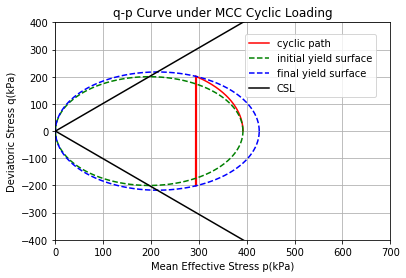

In [314]:
data = [stressCyc, strainCyc]
pp = []
qq = []
devStrain = []
m = data[0].shape[1]
for i in range(m):
    pp.append(getp(data[0][:, i].reshape(-1,1)))
    qq.append(getq(data[0][:, i].reshape(-1,1)))
    devStrain.append(getDevStrain(data[1][:, i].reshape(-1,1)))
plt.plot(pp,qq,'r',label='cyclic path')
    
al = np.arange(0, 2*np.pi, 0.01)
p00 = pCyc[0,0]
x = p00/2.+p00/2.*np.cos(al)
y = p00/2.*M*np.sin(al)
plt.plot(x,y,'g--', label='initial yield surface')
p00 = pCyc[0,-1]
x = p00/2.+p00/2.*np.cos(al)
y = p00/2.*M*np.sin(al)
plt.plot(x,y,'b--', label='final yield surface')

x = np.arange(0,400)
y = M * x
plt.plot(x,y,'k-',label='CSL')
x = np.arange(0,400)
y = -M * x
plt.plot(x,y,'k-')

plt.title('q-p Curve under MCC Cyclic Loading')
plt.xlabel('Mean Effective Stress p(kPa)')
plt.ylabel('Deviatoric Stress q(kPa)')
plt.legend(bbox_to_anchor=(0.55,0.8))
plt.axis([0,700,-400,400])
plt.grid()
#plt.axis('equal')
plt.savefig('q-p curve Cyc.png', dpi=120)
plt.show()

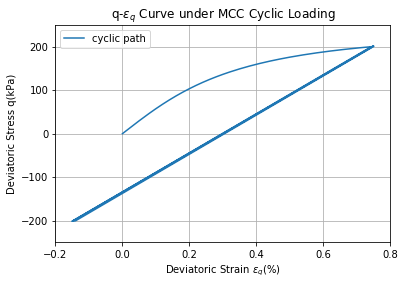

In [326]:
data = [stressCyc, strainCyc]
pp = []
qq = []
devStrain = []
m = data[0].shape[1]
for i in range(m):
    pp.append(getp(data[0][:, i].reshape(-1,1)))
    qq.append(getq(data[0][:, i].reshape(-1,1)))
    devStrain.append(getDevStrain(data[1][:, i].reshape(-1,1))*100)
plt.plot(devStrain,qq,label='cyclic path')

plt.title('q-$\epsilon_q$ Curve under MCC Cyclic Loading')
plt.xlabel('Deviatoric Strain $\epsilon_q$(%)')
plt.ylabel('Deviatoric Stress q(kPa)')
plt.legend()
plt.axis([-0.2,0.8,-250,250])
plt.grid()
plt.savefig('q-strain curve Cyc.png', dpi=120)
plt.show()

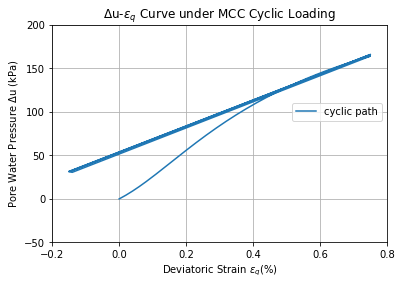

In [325]:
data = [stressCyc, strainCyc]
pp = []
qq = []
devStrain = []
m = data[0].shape[1]
for i in range(m):
    pp.append(getp(data[0][:, i].reshape(-1,1)))
    qq.append(getq(data[0][:, i].reshape(-1,1)))
    devStrain.append(getDevStrain(data[1][:, i].reshape(-1,1))*100)
    ppp = np.array(qq)/3. + pp[0] 
    deltaU = ppp - pp
plt.plot(devStrain,deltaU,label='cyclic path')

plt.title('$\Delta$u-$\epsilon_q$ Curve under MCC Cyclic Loading')
plt.xlabel('Deviatoric Strain $\epsilon_q$(%)')
plt.ylabel('Pore Water Pressure $\Delta$u (kPa)')
plt.legend(loc=5,bbox_to_anchor=(1.0,0.6))
plt.axis([-0.2,0.8,-50,200])
plt.grid()
plt.savefig('u-Strain curve Cyc.png', dpi=120)
plt.show()